# Lennard Jones gas in NVT ensemble

In [82]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [250]:
# Parameter
# all in reduced units
N=100
T=1.5
rho=0.9
V=N/rho
L=V**(1/3)
print(rho,L,V)

0.9 4.807498567691361 111.11111111111111


In [251]:
#lenard jones potential truncated and shifted
rc=2.5
def u(i,j,r_c=rc):
    r=norm(i-(j+L*np.rint((i-j)/L)))
    if r>r_c: 
        return 0
    else:        
        return 4*(r**-12-r**-10+r_c**-12-r_c**-12) 

In [252]:
np.rint((pos[0]-pos[2])/L)#.astype(int)

array([ 1., -1., -1.])

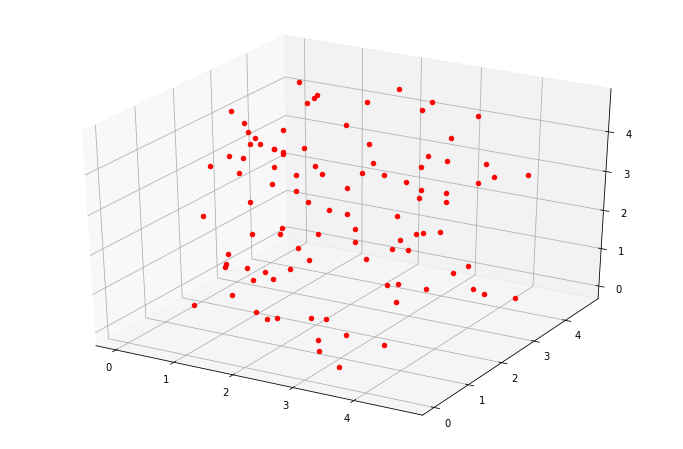

In [253]:
pos=[L*np.random.random(3) for i in range(N)]
fig=plt.figure(figsize=(12,8))
ax=fig.add_subplot(projection='3d')
for x,y,z in pos:
    ax.scatter(x,y,z,'.',c='red')

In [292]:
# Cell list creation
#function that returns index 
def int_cell(part):
    return [np.rint(part[j]//lc).astype(int) for j in range(3)]

#division of the square in more squares
nc=int(L//rc)
lc=L/nc

c=[]
for i in range(nc):
    c.append([])
    for j in range(nc):
        c[i].append([])
        for k in range(nc):
            c[i][j].append([])
            

for i in range(N):
    n1,n2,n3=int_cell(pos[i])
    c[n1][n2][n3].append(i)


In [293]:
# check consistency
# See if the distance between particle in the same cell is less than sqrt(3)lc
R=[]
for cc in c[0][0][0]:
    R.append(pos[cc])
for i in range(len(R)):
    j=i+1
    while j<len(R):
        if not norm(R[i]-R[j])<lc*np.sqrt(3):
            print('Fatal error\n')
        j+=1
R.clear()

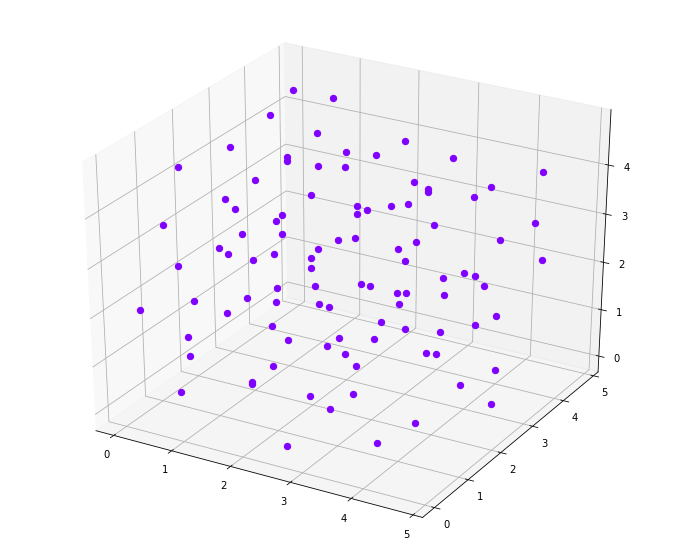

In [294]:
#Graphical view of the cell
#Doesn't help...

l=0
colors = cm.rainbow(np.linspace(0, 1, nc*nc*nc))
fig=plt.figure(figsize=(12,10))
ax=fig.add_subplot(projection='3d')
for i in range(nc):
    for j in range(nc):
        for k in range(nc):
            for cc in c[i][j][k]:
                if cc:
                    x,y,z = pos[cc]
                    ax.scatter(x,y,z,'.',color=colors[l],s=40)
            l+=1

In [295]:
#Energy evaluation
def en():
    e=0.
    for p in range(N):
        n1,n2,n3=int_cell(pos[p])
        e+=sum([0.5*u(pos[p],pos[cc]) for cc in c[n1][n2][n3] if cc!=p and  cc])
        for i in [-1+nc,nc,nc+1]:
            for j in [-1+nc,nc,nc+1]:
                for k in [-1+nc,nc,nc+1]:
                    e+=sum([0.5*u(pos[p],pos[cc]) for cc in c[(n1+i)%nc][(n2+j)%nc][(n3+k)%nc] if cc!=p and cc])
    return e/N
e=en()
e

43.54676538253894

In [296]:
def mcmove_acc(d):
    C=c.copy()
    NN=nn.copy()
    pos2=pos.copy()
    q=0
    for l in range(N):
        p=np.random.randint(0,N)
        xi=(pos2[p]+(0.5-np.random.random(3))*d+L)%L
        e0=0.
        e1=0.
        nn1,nn2,nn3=int_cell(pos2[p])
        for i in [-1+nc,nc,nc+1]:
            for j in [-1+nc,nc,nc+1]:
                for k in [-1+nc,nc,nc+1]:
                    t=[u(pos2[p],pos2[cc]) for cc in C[(nn1+i)%nc][(nn2+j)%nc][(nn3+k)%nc] if cc!=p and cc]
                    e0+=sum(t)

        n1,n2,n3=int_cell(xi)
        for i in [-1+nc,nc,nc+1]:
            for j in [-1+nc,nc,nc+1]:
                for k in [-1+nc,nc,nc+1]:
                    t=[u(xi,pos2[cc]) for cc in C[(n1+i)%nc][(n2+j)%nc][(n3+k)%nc] if cc!=p and cc]
                    e1+=sum(t)
        
        if np.logical_or(e1<=e0,(e1>e0 and np.exp(-(e1-e0)/T)>np.random.random())):
            pos2[p]=xi
            if (p in C[nn1][nn2][nn3] and not np.all([n1,n2,n3]==[nn1,nn2,nn3])):
                C[nn1][nn2][nn3].remove(p)
                C[n1][n2][n3].append(p)
                NN[p]=[n1,n2,n3]
            q+=1
    print(q/N)

In [299]:
for i in range(10):
    mcmove_acc(0.2)

0.65
0.62
0.58
0.68
0.56
0.72
0.57
0.65
0.61
0.66


In [265]:
#mc move
# Move for 0.5 sigma
# update list 
def mcmove(c,nn):
    for l in range(N):
        p=np.random.randint(0,N)
        xi=(pos[p]+(0.5-np.random.random(3))*0.2+L)%L
        e0=0.
        e1=0.
        nn1,nn2,nn3=int_cell(pos[p])
        for i in [-1+nc,nc,nc+1]:
            for j in [-1+nc,nc,nc+1]:
                for k in [-1+nc,nc,nc+1]:
                    t=[u(pos[p],pos[cc]) for cc in c[(nn1+i)%nc][(nn2+j)%nc][(nn3+k)%nc] if cc!=p and cc]
                    e0+=sum(t)

        n1,n2,n3=int_cell(xi)
        for i in [-1+nc,nc,nc+1]:
            for j in [-1+nc,nc,nc+1]:
                for k in [-1+nc,nc,nc+1]:
                    t=[u(xi,pos[cc]) for cc in c[(n1+i)%nc][(n2+j)%nc][(n3+k)%nc] if cc!=p and cc]
                    e1+=sum(t)
        
        if np.logical_or(e1<=e0,(e1>e0 and np.exp(-(e1-e0)/T)>np.random.random())):
            pos[p]=xi
            if (not np.all([n1,n2,n3]==[nn1,nn2,nn3])):
                c[nn1][nn2][nn3].remove(p)
                c[n1][n2][n3].append(p)
    return(c.copy(),nn.copy())

In [266]:
E=[en()]
T=100
for t in range(T):
    c,nn=mcmove(c,nn)
    E.append(en())
    print("Loading " + str(int((t+1)/T*100))+'%',end="\r")

131169445.99165292 43.54676538253894


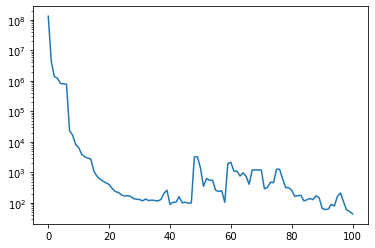

In [281]:
E=np.asarray(E)
plt.plot(E)
plt.yscale('log')
print(E.max(),E.min())

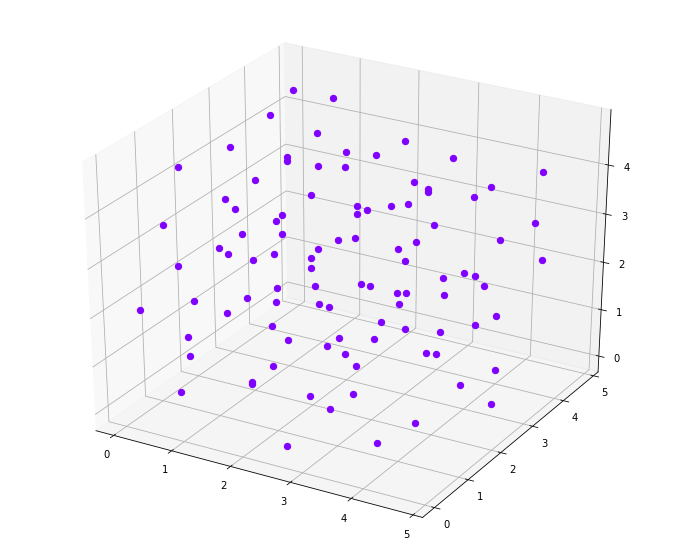

In [268]:
l=0
fig=plt.figure(figsize=(12,10))
ax=fig.add_subplot(projection='3d')
for i in range(nc):
    for j in range(nc):
        for k in range(nc):
            for cc in c[i][j][k]:
                if cc:
                    x,y,z = pos[cc]
                    ax.scatter(x,y,z,'.',color=colors[l],s=40)
            l+=1

(array([68., 13.,  2.,  1.,  4.,  1.,  1.,  0.,  0.,  1.]),
 array([  43.54676538,  685.04368411, 1326.54060283, 1968.03752156,
        2609.53444028, 3251.03135901, 3892.52827774, 4534.02519646,
        5175.52211519, 5817.01903391, 6458.51595264]),
 <a list of 10 Patch objects>)

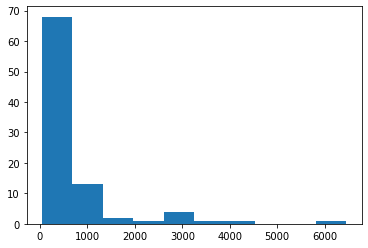

In [310]:
plt.hist(E[10:])

In [301]:
R=[]
for i in range(N):
    for j in range(i+1,N):
            R.append(norm((pos[i]-pos[j]+L)%L))
R=np.asarray(R)

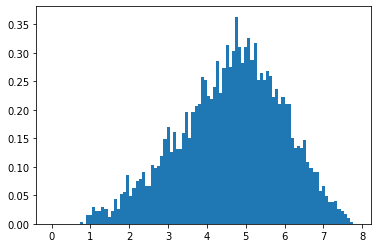

In [305]:
dr=0.08
bins=np.arange(0,np.amax(R)+2*dr,dr)
nm=plt.hist(R,bins,density=True)

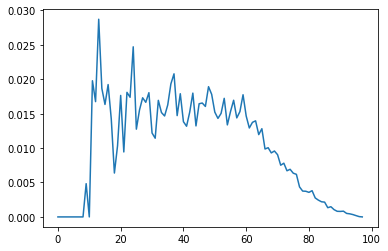

In [308]:
r=nm[1]
n=nm[0]
g=[]
for i in range(n.shape[-1]):
    g.append(n[i]/(rho*4/3*np.pi*(r[i+1]**3-r[i]**3))) 
plt.plot(g)

## Alternative cell list

In [290]:
#Create cell_list and a vector with cell index of particles in the list
#can be usefull for the energy

def cell_list():
    nc=int(L/rc)
    lc=L/nc
    c=[[] for i in range(nc*nc*nc)]
    nn=np.zeros(N,dtype=int)
    for i in range(N):
        n=sum([int(pos[i][j]/lc)*nc**j for j in range(3)])
        nn[i]=n
        c[n].append(i)
    return c,nn

c,nc=cell_list()
print(c,'\n',nc)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]] 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
